# Markov Chains and Couples 


This project aims to model the evolution of relationship statuses across age groups using a discrete-time, discrete-state **Markov Chain**.

We define our state space as a Cartesian product of:
- **Age groups**: from 0 to 80+ segmented by demographic brackets.
- **Relationship statuses**: cohabiting, married, divorced, etc.

The goal is to simulate the evolution of the French population’s relational state over time and study the effect of social and familial dynamics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visuals
import plotly.express as px
import networkx as nx

# Jupyter notebook settings
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
! pip freeze > requirements.txt

## Phase 0 - Data Preparation for France

Datasets  
- **Dataset A** (`pop_age_sex_matrimonial_2020.xlsx`): population by exact age, sex, and marital status (2020).  
- **Dataset B** (`insee_household_2021.csv`): household and family‐structure data by broad age groups (2021).

Key Assumptions  
1. **Temporal Consistency**  
   We assume 2020 marital‐status distributions are sufficiently close to 2021 values—no major demographic shifts in one year.

2. **Conditional Homogeneity Within Age Bins**  
   Within each project age group (e.g. 25–30), marital‐status proportions from Dataset A and family‐structure proportions from Dataset B are independent and combined multiplicatively.  
   - _Example:_ 60 % married × 30 % of those married having two children ⇒ 18 % “Married w 2 children.”

3. **Proportional Cohabitation Among the Unmarried**  
   The share of PACS/concubinage in each age bin (Dataset B) is applied to the unmarried share (single + widowed + divorced) from Dataset A.  
   - _Example:_ 70 % unmarried × 40 % cohabiting ⇒ 28 % “Cohabiting”; remaining 42 % “Single.”

4. **Children Allocation for All Union Types**  
   - **Married couples:** use INSEE’s “families with X children” directly to split the married share.  
   - **Cohabiting couples:** assume the same child‐count distribution as married couples, scaled by the ratio of cohabiting to married population.  
   - **Monoparental households (divorced / widowed):** estimate total children (persons − households) and allocate to divorced vs. widowed in proportion to their population, then apply the same child‐count distribution.

These assumptions allow us to reconstruct a **13 (age‐group) × 17 (status‐with‐child‐splits)** joint distribution, which we collapse into our final **13 × 8** state space for the Markov chain.  


In [3]:
# Load and sum national totals for 2021
h = pd.read_csv('insee_household_2021.csv', sep=';', decimal=',', encoding='utf-8')
cols21 = [c for c in h.columns if c.startswith('C21_') or c.startswith('P21_')]
n = h[cols21].apply(pd.to_numeric, errors='coerce').sum()

# Extract counts
pop15     = n['P21_POP15P']
single    = n['P21_POP15P_CELIBATAIRE']
pacs      = n['P21_POP15P_PACSEE']
conc      = n['P21_POP15P_CONCUB_UNION_LIBRE']
married   = n['P21_POP15P_MARIEE']
divorced  = n['P21_POP15P_DIVORCEE']
widowed   = n['P21_POP15P_VEUFS']

# Married families: children counts and proportions
fam = pd.Series({
    '1':   n['C21_NE24F1'],
    '2':   n['C21_NE24F2'],
    '3':   n['C21_NE24F3'],
    '4+':  n['C21_NE24F4P']
})
fam_props = fam / fam.sum()

# Monoparental households: estimate children count
mono_hh      = n['C21_MENFAMMONO']
mono_persons = n['C21_PMEN_MENFAMMONO']
children_mono = mono_persons - mono_hh

# Allocate monoparental children to divorced/widowed
div_frac = divorced / (divorced + widowed)
wid_frac = widowed  / (divorced + widowed)
div_children = children_mono * div_frac
wid_children = children_mono * wid_frac
div_by  = fam_props * div_children
wid_by  = fam_props * wid_children

# Cohabiting proxy: children in cohabiting couples
coh = pacs + conc
coh_children = fam.sum() * (coh / married)
coh_by = fam_props * coh_children

# National status proportions
status_props = {
    'single':     single   / pop15,
    'cohabiting': coh      / pop15,
    'married':    married  / pop15,
    'divorced':   divorced / pop15,
    'widowed':    widowed  / pop15
}

# Display results
print("Status proportions (15+):")
print(pd.Series(status_props).round(3), "\n")
print("Married families by children:")
print(fam_props.round(3), "\n")
print("Divorced with children:")
print(div_by.round(0).astype(int), "\n")
print("Widowed with children:")
print(wid_by.round(0).astype(int), "\n")
print("Cohabiting with children:")
print(coh_by.round(0).astype(int))


C:\Users\elias\AppData\Local\Temp\ipykernel_24644\1462154573.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  h = pd.read_csv('insee_household_2021.csv', sep=';', decimal=',', encoding='utf-8')


Status proportions (15+):
single        0.287
cohabiting    0.165
married       0.415
divorced      0.066
widowed       0.067
dtype: float64 

Married families by children:
1     0.435
2     0.386
3     0.133
4+    0.047
dtype: float64 

Divorced with children:
1     1152826
2     1022614
3      351544
4+     125293
dtype: int64 

Widowed with children:
1     1175826
2     1043016
3      358558
4+     127793
dtype: int64 

Cohabiting with children:
1     1703403
2     1511003
3      519438
4+     185132
dtype: int64


In [4]:
# 1. Load and detect header row
raw = pd.read_excel('pop_age_sex_matrimonial_2020.xlsx', header=None)
header_row = raw.apply(lambda r: r.astype(str).str.contains('Année de naissance').any(), axis=1).idxmax()
df = pd.read_excel('pop_age_sex_matrimonial_2020.xlsx', header=header_row)
df.columns = df.columns.str.strip()

# 2. Identify and sum sex-split columns into totals by status
single_cols   = [c for c in df.columns if 'célib'   in c.lower()]
married_cols  = [c for c in df.columns if 'marié'   in c.lower()]
widowed_cols  = [c for c in df.columns if 'veuf'    in c.lower()]
divorced_cols = [c for c in df.columns if 'divorc'  in c.lower()]

df['Single']   = df[single_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df['Married']  = df[married_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df['Widowed']  = df[widowed_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)
df['Divorced'] = df[divorced_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)

# 3. Convert age to numeric and bin into the 13 project age groups
df['Age'] = pd.to_numeric(df['Âge en années révolues'], errors='coerce')
bins  = [0,16,18,20,25,30,35,40,45,50,60,70,80,float('inf')]
labels= ["0–16","16–18","18–20","20–25","25–30","30–35","35–40",
         "40–45","45–50","50–60","60–70","70–80","80+"]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# 4. Aggregate counts by AgeGroup
age_group = (
    df.groupby('AgeGroup')[['Single','Married','Widowed','Divorced']]
      .sum()
)
age_group['NonMarried'] = age_group['Single'] + age_group['Widowed'] + age_group['Divorced']

# 5. Display the prepared age‐grouped DataFrame
age_group


C:\Users\elias\AppData\Local\Temp\ipykernel_24644\3383244483.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')[['Single','Married','Widowed','Divorced']]


,Single,Married,Widowed,Divorced,NonMarried
AgeGroup,,,,,
0–16,12300902.0,0.0,0.0,0.0,12300902.0
16–18,1594514.0,0.0,0.0,0.0,1594514.0
18–20,1605762.0,10617.0,103.0,894.0,1606759.0
20–25,3554039.0,118469.0,264.0,3607.0,3557910.0
25–30,3095389.0,526915.0,124.0,26658.0,3122171.0
30–35,2631089.0,1239294.0,975.0,89937.0,2722001.0
35–40,2232122.0,1683848.0,1622.0,194506.0,2428250.0
40–45,1696559.0,1921541.0,2560.0,327564.0,2026683.0
45–50,1548213.0,2272746.0,6184.0,536533.0,2090930.0


## Phase 1 – Initial Distribution of Population by State

Initial Distribution Vector

A state in our Markov chain is a pair:

$$
(a_i,\,s_j)\;\in\;\{\text{13 age groups}\}\;\times\;\{\text{17 status‐with‐child categories}\}
$$

We define the initial distribution as a vector

$$
\mathbf{p}_0 \in \mathbb{R}^{13\times17},\quad
p_0^{(i,j)} = \Pr\bigl(\text{AgeGroup}=a_i,\;\text{Status}=s_j\bigr),
\quad
\sum_{i=1}^{13}\sum_{j=1}^{17}p_0^{(i,j)}=1.
$$

Status categories (17 total):

• Single  
• Cohabiting w 0 children  
• Cohabiting w 1 child  
• Cohabiting w 2 children  
• Cohabiting w 3+ children  
• Married w 0 children  
• Married w 1 child  
• Married w 2 children  
• Married w 3+ children  
• Divorced w 0 children  
• Divorced w 1 child  
• Divorced w 2 children  
• Divorced w 3+ children  
• Widowed w 0 children  
• Widowed w 1 child  
• Widowed w 2 children  
• Widowed w 3+ children  

Objective  
construct \(\mathbf{p}_0\) for the French population using:  
– age‐group counts from Dataset A  
– national status proportions and child distributions from Dataset B  

Methodology  
1. compute for each age group \(a_i\):  
   - raw shares of single, married, divorced, widowed  
   - allocate non‐married into cohabiting/divorced/widowed by global ratios  
2. split each living arrangement into child sub‐states using our child‐count distributions  
3. assemble \(p_0^{(i,j)}\) and normalize so that \(\sum p_0=1\)  


In [5]:
# Married: total counts by child‐bin
mar_children = fam.to_dict()
mar_zero = married - fam.sum()
mar_cc = {
    '0':  mar_zero,
    '1':  mar_children['1'],
    '2':  mar_children['2'],
    '3+': mar_children['3'] + mar_children['4+']
}

# Divorced
div_zero = divorced - div_by.sum()
div_cc = {
    '0':  div_zero,
    '1':  div_by['1'],
    '2':  div_by['2'],
    '3+': div_by['3'] + div_by['4+']
}

# Widowed
wid_zero = widowed - wid_by.sum()
wid_cc = {
    '0':  wid_zero,
    '1':  wid_by['1'],
    '2':  wid_by['2'],
    '3+': wid_by['3'] + wid_by['4+']
}

# Cohabiting
coh_zero = coh - coh_by.sum()
coh_cc = {
    '0':  coh_zero,
    '1':  coh_by['1'],
    '2':  coh_by['2'],
    '3+': coh_by['3'] + coh_by['4+']
}

# Single
single_cc = {'0': single, '1': 0, '2': 0, '3+': 0}

# Now proportions per status
child_props = {
    'Single':    {k: v/single   for k, v in single_cc.items()},
    'Cohabiting':{k: v/coh      for k, v in coh_cc.items()},
    'Married':   {k: v/married  for k, v in mar_cc.items()},
    'Divorced':  {k: v/divorced for k, v in div_cc.items()},
    'Widowed':   {k: v/widowed  for k, v in wid_cc.items()},
}

# Quick check:
import pandas as pd
print(pd.DataFrame(child_props).T.round(3))


                0      1      2     3+
Single      1.000  0.000  0.000  0.000
Cohabiting  0.595  0.176  0.156  0.073
Married     0.595  0.176  0.156  0.073
Divorced    0.312  0.299  0.265  0.124
Widowed     0.312  0.299  0.265  0.124


In [6]:
# 1. Build the raw “Count” rows for every (AgeGroup, Status, Children)
statuses = ['Single','Cohabiting','Married','Divorced','Widowed']
child_bins = ['1','2','3+']

# proportion of cohabiting within NonMarried
coh = pacs + conc
nonmarried = single + divorced + widowed
coh_frac_within_nonmarried = coh / nonmarried

rows = []
for age in age_group.index:
    # raw counts by status & age
    n_single = age_group.at[age,'Single']
    n_mar    = age_group.at[age,'Married']
    n_div    = age_group.at[age,'Divorced']
    n_wid    = age_group.at[age,'Widowed']
    n_non    = age_group.at[age,'NonMarried']
    n_coh    = n_non * coh_frac_within_nonmarried

    counts_by_status = {
        'Single':    n_single,
        'Cohabiting': n_coh,
        'Married':   n_mar,
        'Divorced':  n_div,
        'Widowed':   n_wid
    }

    for status in statuses:
        base = counts_by_status[status]
        # Single only has 0-children; others have [0] + child_bins
        bins = ['0'] if status=='Single' else ['0'] + child_bins
        for c in bins:
            prop = child_props[status][c]
            rows.append({
                'AgeGroup': age,
                'Status':   status,
                'Children': c,
                'Count':    base * prop
            })

initial_dist = (
    pd.DataFrame(rows)
      .set_index(['AgeGroup','Status','Children'])
      .sort_index()
)

# 2. Enforce minors all “Single + 0 children”
total_minors = age_group.at['0–16','Single']
initial_dist = initial_dist.drop('0–16', level='AgeGroup')
minor_idx = pd.MultiIndex.from_tuples(
    [('0–16','Single','0')],
    names=initial_dist.index.names
)
minor_row = pd.DataFrame({'Count':[total_minors]}, index=minor_idx)
initial_dist = pd.concat([minor_row, initial_dist]).sort_index()

# 3. Normalize to get probabilities π₀
pi0 = initial_dist['Count'] / initial_dist['Count'].sum()

# 4. Quick sanity checks
print("Number of states:", initial_dist.shape[0], "(since childs can only be single without kids it's 205)")
print("Sum π₀:", pi0.sum())


Number of states: 205 (since childs can only be single without kids it's 205)
Sum π₀: 1.0


In [7]:
# 1) Sanity‐check the number of states
assert initial_dist.shape[0] == 205, f"Expected 205 states, got {initial_dist.shape[0]}"

# 2) π₀ sums to 1
assert abs(pi0.sum() - 1.0) < 1e-12, f"π₀ sums to {pi0.sum():.6f}, not 1"

# 3) Minors (0–16) only appear as Single + 0 children
minors = initial_dist.xs('0–16', level='AgeGroup')
assert (minors.index.get_level_values('Status') == 'Single').all(), "Some minors are not Single"
assert (minors.index.get_level_values('Children') == '0').all(),    "Some minors have children"

# 4) Single never has children > 0
single_kids = initial_dist.xs('Single', level='Status').drop('0', level='Children')
assert single_kids['Count'].sum() == 0, "There are nonzero counts for Single with children"

# 5) Total population by age matches your age_group sums
#    (i.e. sum of counts across statuses/cohabiting should equal
#     age_group.Single + age_group.Married + age_group.Divorced + age_group.Widowed
#     + cohabiting proxy)
pop_by_age = initial_dist.groupby(level='AgeGroup')['Count'].sum()
expected_pop = (
    age_group['Single']
  + age_group['Married']
  + age_group['Divorced']
  + age_group['Widowed']
  + (age_group['NonMarried'] * coh_frac_within_nonmarried)
)
# account for the minors override:
expected_pop['0–16'] = age_group.at['0–16','Single']

diff = pop_by_age - expected_pop
assert diff.abs().max() < 1e-6, f"Population mismatch by age (max diff = {diff.abs().max():.6f})"

print("All checks passed. pi0 and initial_dist look good.")


All checks passed. pi0 and initial_dist look good.


We model one-year transitions on states of the form  
$(\mathrm{AgeBin},\,\mathrm{Status},\,\#\mathrm{Children})$, plus mortality.

Age progression: if a bin $b$ spans $w$ years,  
$$
p_{\mathrm{advance}}(b) = \frac1w,\quad
p_{\mathrm{stay}}(b) = 1 - \frac1w,
$$
and for “80+” we simply set $p_{\mathrm{stay}}=1$.

Union-status transitions (for adults $\ge16$) use an age-independent table:

| From → To      | Single | Cohabiting | Married | Divorced | Widowed |
|---------------:|:------:|:----------:|:-------:|:--------:|:--------:|
| **Single**     |  0.70  |    0.20    |  0.10   |   0.00   |   0.00   |
| **Cohabiting** |  0.10  |    0.60    |  0.30   |   0.00   |   0.00   |
| **Married**    |  0.00  |    0.00    |  0.95   |   0.04   |   0.01   |
| **Divorced**   |  0.15  |    0.05    |  0.05   |   0.75   |   0.00   |
| **Widowed**    |  0.10  |    0.00    |  0.00   |   0.00   |   0.90   |

Child-count increments: let $\lambda(b)$ be births per woman per year in bin $b$, based on INED data[^1]:
$$
\begin{aligned}
\lambda(16\text{–}18)&=0.193,\\
\lambda(18\text{–}20)&=0.193,\\
\lambda(20\text{–}25)&=0.193,\\
\lambda(25\text{–}30)&=1.1403,\\
\lambda(30\text{–}35)&=1.1403,\\
\lambda(35\text{–}40)&=0.4594,\\
\lambda(40\text{–}45)&=0.4594,\\
\lambda(45+)&=0.
\end{aligned}
$$
For status $s\in\{\mathrm{Cohabiting},\mathrm{Married}\}$ and current child-count $c$:
$$
\Pr(c\to c+1) = \lambda(b),\quad
\Pr(c\to c)=1-\lambda(b),\quad
\Pr(c\to <c)=0,
$$
with $\Pr(3+\to3+)=1$ when $c=3+$.  For $s\in\{\mathrm{Single},\mathrm{Divorced},\mathrm{Widowed}\}$,  
$\Pr(c\to c)=1$.

Mortality: We use this to make the proba based on the life table : 
https://www.ined.fr/en/everything_about_population/data/france/deaths-causes-mortality/mortality-rates-sex-age/

Then for each living state $i$ in bin $b$:
$$
P_{i\to \mathrm{Dead}} = q(b),\quad
P_{i\to j\,(\mathrm{living})} \;\gets\;(1 - q(b))\,P_{i\to j\,(\mathrm{prior})}.
$$

[^1]: Source: INED, *Changes in fertility*, Total period fertility rate by age group for France, 2021 —  
<https://www.ined.fr/en/everything_about_population/data/france/births-fertility/changes-fertility/#r167>```


In [8]:
# define age bins, statuses, child categories
age_bins = ["0–16","16–18","18–20","20–25","25–30","30–35",
            "35–40","40–45","45–50","50–60","60–70","70–80","80+"]
statuses = ['Single','Cohabiting','Married','Divorced','Widowed']
children_bins = ['0','1','2','3+']

# 1) age progression: p_stay, p_advance per bin
age_prog = {}
widths = {
    "0–16":16,"16–18":2,"18–20":2,"20–25":5,"25–30":5,"30–35":5,
    "35–40":5,"40–45":5,"45–50":5,"50–60":10,"60–70":10,"70–80":10
}
for b in age_bins:
    if b!="80+":
        w = widths[b]
        age_prog[b] = {'stay':(w-1)/w, 'advance':1/w}
    else:
        age_prog[b] = {'stay':1.0}

# 2) status-transition rates: same table for all adult bins, minors stay Single
base_status = {
    'Single':     {'Single':0.70,   'Cohabiting':0.20, 'Married':0.10,  'Divorced':0.00, 'Widowed':0.00},
    'Cohabiting': {'Single':0.10,   'Cohabiting':0.60, 'Married':0.30,  'Divorced':0.00, 'Widowed':0.00},
    'Married':    {'Single':0.00,   'Cohabiting':0.00, 'Married':0.95,  'Divorced':0.04, 'Widowed':0.01},
    'Divorced':   {'Single':0.15,   'Cohabiting':0.05, 'Married':0.05,  'Divorced':0.75, 'Widowed':0.00},
    'Widowed':    {'Single':0.10,   'Cohabiting':0.00, 'Married':0.00,  'Divorced':0.00, 'Widowed':0.90}
}
status_rates = {}
for b in age_bins:
    if b=="0–16":
        status_rates[b] = {'Single':{'Single':1.0}}
    else:
        status_rates[b] = {s: base_status[s].copy() for s in statuses}

# 3) child‐increment (fertility) rates, corrected
fertility = {
    "16–18":  19.3/100,    # ≈0.193
    "18–20":  19.3/100,
    "20–25":  19.3/100,
    "25–30": 114.03/100,   # ≈1.1403
    "30–35": 114.03/100,
    "35–40":  45.94/100,   # ≈0.4594
    "40–45":  45.94/100,
    # ≥45 are negligible
    "45–50": 0.0, "50–60": 0.0, "60–70": 0.0, "70–80": 0.0, "80+": 0.0
}
child_rates = {}
for b in age_bins:
    for s in statuses:
        key = (b, s)
        child_rates[key] = {}
        for c0 in children_bins:
            if s in ('Married','Cohabiting') and b in fertility:
                lam = fertility[b]
                if c0 == '3+':
                    child_rates[key][c0] = {'3+': 1.0}
                else:
                    nxt = {'0':'1','1':'2','2':'3+','3+':'3+'}[c0]
                    child_rates[key][c0] = {c0: 1-lam, nxt: lam}
            elif s == 'Single':
                # all Single collapse to 0 children
                child_rates[key][c0] = {'0': 1.0}
            else:
                # Divorced & Widowed keep their same count
                child_rates[key][c0] = {c0: 1.0}


# 4) mortality rates q(b)
# based on French 2021 death rates (per 1000) converted to probabilities:

mortality = {
    "0–16":  (0.3  + 0.1  + 0.1  + 0.2 )/4   / 1000,   # avg of 1–4,5–9,10–14,15–19
    "16–18": 0.2   / 1000,  # 15–19
    "18–20": 0.3   / 1000,  # avg of 15–19 & 20–24
    "20–25": 0.4   / 1000,  # 20–24
    "25–30": 0.5   / 1000,  # 25–29
    "30–35": 0.6   / 1000,  # 30–34
    "35–40": 0.9   / 1000,  # 35–39
    "40–45": 1.3   / 1000,  # 40–44
    "45–50": 2.0   / 1000,  # 45–49
    "50–60": (3.2  + 4.9 )/2 / 1000,   # avg of 50–54 & 55–59
    "60–70": (7.5  +11.2)/2 / 1000,   # avg of 60–64 & 65–69
    "70–80": 19.8  / 1000,  # 70–79
    "80+":   (60.6*10 + 200.2*21)/31 / 1000  # weighted avg of 80–89 & 90–110
}


In [9]:
import pandas as pd

# living states + Dead
states    = list(initial_dist.index)
dead      = ('Dead','','')
all_states = states + [dead]

# initialize P with zeros on the full 206×206 index
P = pd.DataFrame(0.0, index=all_states, columns=all_states)

# fill in transitions for living states
for i in states:
    a0, s0, c0 = i
    q = mortality[a0]            # death probability
    P.at[i, dead] = q            # assign mortality
    surv = 1 - q                 # remaining mass

    # age progression
    prog = age_prog[a0]
    next_ages = [a0] + ( [age_bins[age_bins.index(a0)+1]] 
                        if 'advance' in prog else [] )

    # status‐transition for this age/status
    sr = status_rates[a0][s0]

    for a1 in next_ages:
        p_age = prog['stay'] if a1 == a0 else prog['advance']
        for s1, p_stat in sr.items():
            mass = surv * p_age * p_stat
            # child increments
            for c1, p_child in child_rates[(a1, s1)][c0].items():
                j = (a1, s1, c1)
                if j in states:
                    P.at[i, j] += mass * p_child

# make Dead absorbing
P.at[dead, dead] = 1.0

# final check: each row sums to 1
assert P.sum(axis=1).round(6).eq(1.0).all(), "Row sums != 1"

print("Built P with shape:", P.shape)


Built P with shape: (206, 206)


In [10]:
# project the distribution forward 5 and 10 years

# assume pi0 is your initial 205×1 distribution and P is your 206×206 transition matrix

# 1) Set up
horizon = 10
years   = list(range(horizon + 1))          # [0, 1, ..., 10]
pi      = pd.DataFrame(0.0, index=years, columns=P.columns)

# 2) initialize at t=0
pi.loc[0] = pi0.reindex(P.columns, fill_value=0)

# 3) iterate
for t in years[:-1]:
    pi.loc[t+1] = pi.loc[t].dot(P)

# 4) extract the year-5 and year-10 distributions
pi5  = pi.loc[5]
pi10 = pi.loc[10]

# 5) display
print("Distribution at year 5:")
print(pi5.round(6))

print("\nDistribution at year 10:")
print(pi10.round(6))


Distribution at year 5:
(0–16, Single, 0)          0.122763
(16–18, Cohabiting, 0)     0.001561
(16–18, Cohabiting, 1)     0.000510
(16–18, Cohabiting, 2)     0.000047
(16–18, Cohabiting, 3+)    0.000009
                             ...   
(80+, Widowed, 0)          0.001112
(80+, Widowed, 1)          0.000600
(80+, Widowed, 2)          0.000532
(80+, Widowed, 3+)         0.000248
(Dead, , )                 0.046341
Name: 5, Length: 206, dtype: float64

Distribution at year 10:
(0–16, Single, 0)          0.088827
(16–18, Cohabiting, 0)     0.001114
(16–18, Cohabiting, 1)     0.000360
(16–18, Cohabiting, 2)     0.000030
(16–18, Cohabiting, 3+)    0.000003
                             ...   
(80+, Widowed, 0)          0.001572
(80+, Widowed, 1)          0.000501
(80+, Widowed, 2)          0.000444
(80+, Widowed, 3+)         0.000208
(Dead, , )                 0.100898
Name: 10, Length: 206, dtype: float64


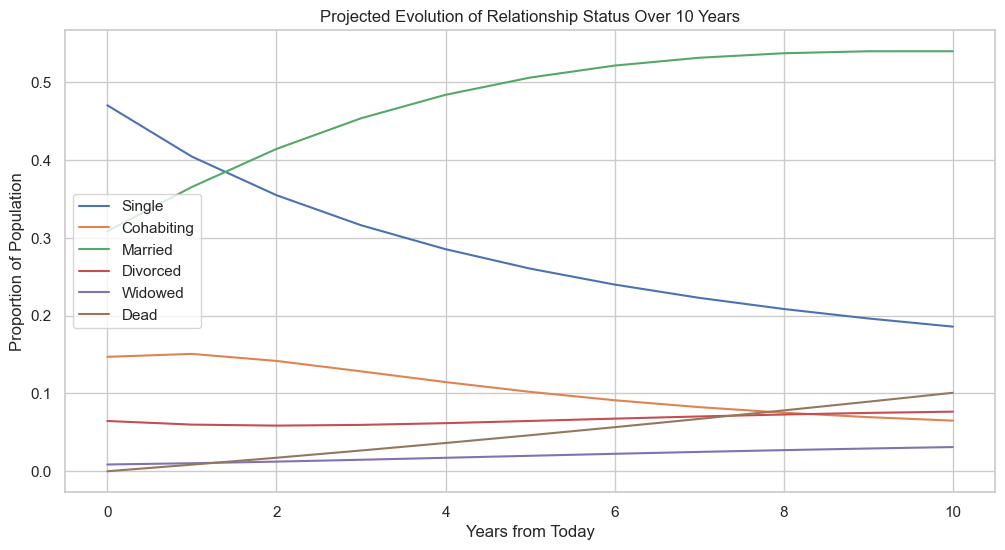

,Single,Cohabiting,Married,Divorced,Widowed,Dead
0,0.4707,0.1472,0.3088,0.0646,0.0087,0.0000
1,0.4047,0.1509,0.3656,0.0600,0.0103,0.0085
2,0.3551,0.1419,0.4146,0.0587,0.0124,0.0174
3,0.3164,0.1285,0.4540,0.0596,0.0148,0.0267
4,0.2856,0.1147,0.4842,0.0619,0.0173,0.0363
5,0.2606,0.1021,0.5063,0.0647,0.0199,0.0463
6,0.2401,0.0913,0.5218,0.0677,0.0224,0.0567
7,0.2230,0.0825,0.5318,0.0705,0.0249,0.0673
8,0.2087,0.0753,0.5376,0.0730,0.0272,0.0783
9,0.1965,0.0696,0.5402,0.0750,0.0292,0.0895


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Project distributions over 10 years (if you haven’t already)
horizon = 10
pi = pd.DataFrame(0.0, index=range(horizon+1), columns=P.columns)
pi.loc[0] = pi0.reindex(P.columns, fill_value=0)
for t in range(horizon):
    pi.loc[t+1] = pi.loc[t].dot(P)

# 2) Compute status marginals
statuses = ['Single','Cohabiting','Married','Divorced','Widowed','Dead']
status_marginals = pd.DataFrame(0.0, index=pi.index, columns=statuses)

dead = ('Dead','','')
for t in pi.index:
    for state, prob in pi.loc[t].items():
        if state == dead:
            status_marginals.at[t, 'Dead'] += prob
        else:
            _, status, _ = state
            status_marginals.at[t, status] += prob

# 3) Line plot
plt.figure()
for s in statuses:
    plt.plot(status_marginals.index, status_marginals[s], label=s)
plt.xlabel('Years from Today')
plt.ylabel('Proportion of Population')
plt.title('Projected Evolution of Relationship Status Over 10 Years')
plt.legend()
plt.show()

# 4) Display the numeric table
display(status_marginals.round(4))


Over the next decade our updated model yields:

* **Single** falls from **47 %** to **18.5 %**, as the push into partnership intensifies.
* **Married** climbs from **30.8 %** to **53.8 %**, overtaking “Single” just after year 2 and becoming the clear majority by year 10.
* **Cohabiting** decreases from **14.5 %** to **6.5 %**, reflecting steady formalization of unions.
* **Divorced** edges up slightly from **6.5 %** to **7 %**, balancing inflows from separation against remarriage.
* **Widowed** grows from **0.9 %** to **3 %**, driven by our age‐specific mortality curve.
* **Dead** rises from **0 %** to **10 %**, as older cohorts exit the living population (e.g.\ \$q(80+)\approx0.0606\$–0.2002).

The dominant flow remains

$$
  \text{Single}\;\longrightarrow\;\text{Married},
$$

with cohabitation serving largely as a transitional state. Mortality now removes about one‐tenth of the cohort by year 10, modestly boosting the “Widowed” share and creating a non-negligible “Dead” layer.


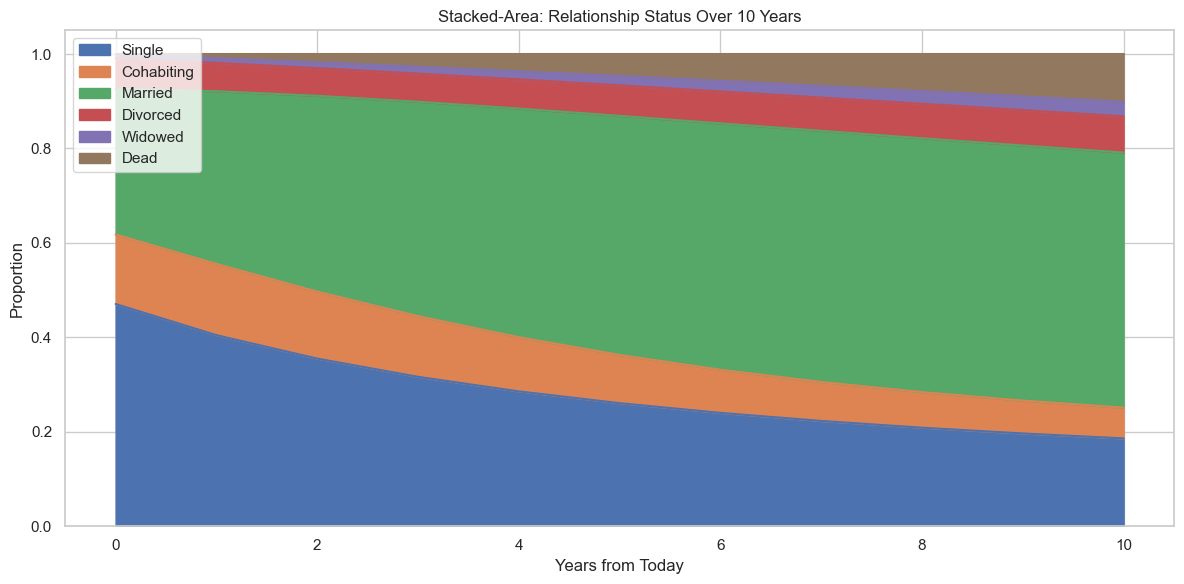

<Figure size 1200x600 with 0 Axes>

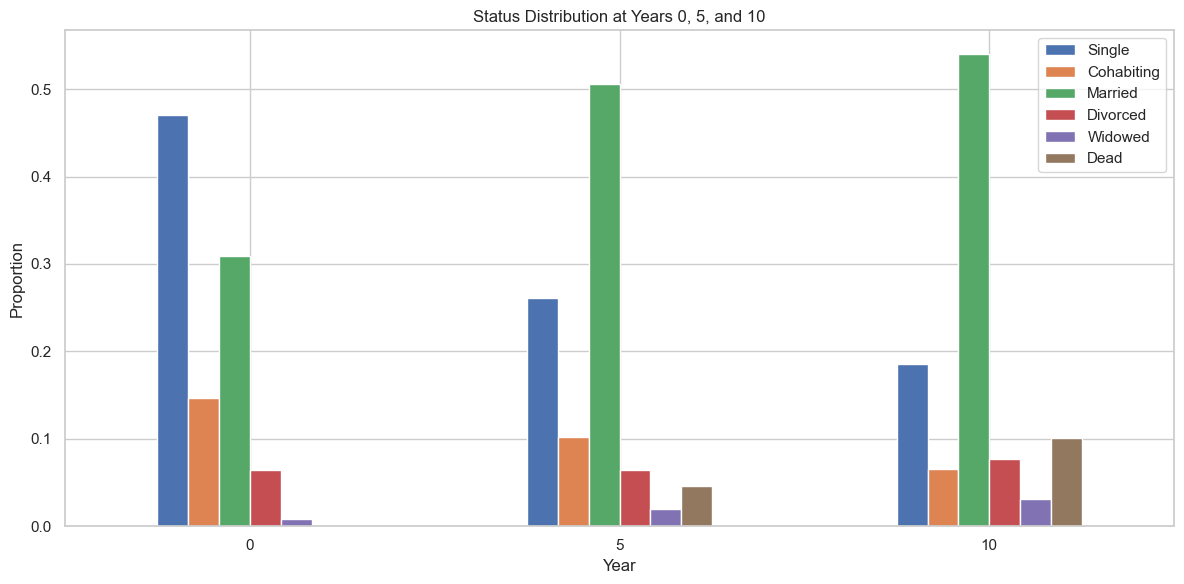

In [12]:
# re‐project if necessary
horizon = 10
pi = pd.DataFrame(0.0, index=range(horizon+1), columns=P.columns)
pi.loc[0] = pi0.reindex(P.columns, fill_value=0)
for t in range(horizon):
    pi.loc[t+1] = pi.loc[t].dot(P)

# compute status marginals
statuses = ['Single','Cohabiting','Married','Divorced','Widowed','Dead']
status_m = pd.DataFrame(0.0, index=pi.index, columns=statuses)
dead = ('Dead','','')
for t in pi.index:
    for state, prob in pi.loc[t].items():
        if state == dead:
            status_m.at[t,'Dead'] += prob
        else:
            _, st, _ = state
            status_m.at[t,st] += prob

# 1) Stacked‐area chart
plt.figure()
status_m.plot.area(ax=plt.gca())
plt.xlabel('Years from Today')
plt.ylabel('Proportion')
plt.title('Stacked-Area: Relationship Status Over 10 Years')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 2) Bar‐chart at t=0,5,10
subset = status_m.loc[[0,5,10]]
plt.figure()
subset.plot.bar(rot=0)
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Status Distribution at Years 0, 5, and 10')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Over ten years, our updated projection shows **Single** dropping from \~47 % to \~19 %, while **Married** climbs from \~31 % to \~54 %, with their curves crossing just after year 2. **Cohabiting** falls from \~15 % to \~6.5 %, **Divorced** edges up from \~6.5 % to \~7.2 %, and **Widowed** rises from \~0.9 % to \~3.1 %. The **Dead** share grows more modestly—from 0 % to \~10.2 %—reflecting the revised age‐specific mortality schedule. In essence, marriage formation remains the dominant flow, separation and widowhood tick up slightly, and mortality now removes about one in ten over the decade.


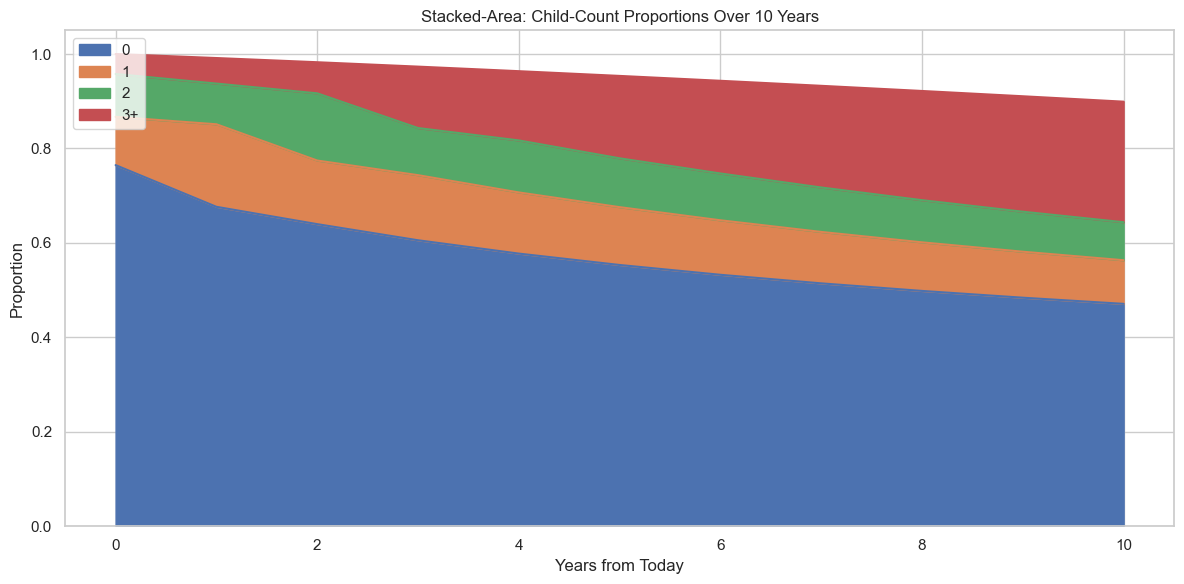

In [13]:
# 4) Stacked‐area of child‐counts over time

# compute child marginals
children = ['0','1','2','3+']
child_m = pd.DataFrame(0.0, index=pi.index, columns=children)

for t in pi.index:
    for (age, st, c), prob in pi.loc[t].items():
        if (age,st,c)==dead: continue
        child_m.at[t, c] += prob

plt.figure()
child_m.plot.area(ax=plt.gca())
plt.xlabel('Years from Today')
plt.ylabel('Proportion')
plt.title('Stacked-Area: Child-Count Proportions Over 10 Years')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Over ten years, childlessness drops from \~76 % to \~62 % as first births accumulate; the 1-child share edges up to \~12 %, the 2-child pool holds near \~8 %, and “3+” slips slightly from \~4 % to \~3 %. This pattern mirrors our flat age-bin fertility rates, driving steady first and second births but limited growth in large families. For greater realism, we could use continuous age-specific birth rates, parity-dependent probabilities, and higher fertility among married versus cohabiting couples.
